# Finetune VGG16

## Importing Stuff

In [5]:
# setting up stuff
import numpy as np

from keras.models import Model
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing import image

Using TensorFlow backend.


In [6]:
import cv2
from PIL import Image
from sklearn.metrics import mean_squared_error

In [16]:
from scipy import misc
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [8]:
import os
import re

## Load base VGG Model and Weights

In [127]:
# load the base pre-trained model
base_model = VGG16()

In [6]:
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

## Chop off the Last layer, add fc (1000) & fc(4)

In [128]:
fc2 = base_model.get_layer('fc2').output
fc3 = Dense(1000, activation='relu')(fc2)
predictions = Dense(4)(fc3)

In [129]:
# this is the model we will train
model = Model(base_model.input, predictions)

In [130]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

## Freeze the base VGG

In [131]:
for layer in base_model.layers:
    layer.trainable = False

## Read Data and BB

In [97]:
def scale_bb(bb, source_dim, target_dim=(224,224)):
    x_l, y_l, x_r, y_r = bb
    n_s, m_s = source_dim
    n_t, m_t = target_dim
    scaled_bb = x_l*n_t/n_s, y_l*m_t/m_s, x_r*n_t/n_s, y_r*m_t/m_s
    return list(map(int, scaled_bb))

In [105]:
def parse_bb(folder):
    arr = {}
    base = 'data/{}/Annotations/'.format(folder)
    for file in os.listdir(base):
        with open(base + file) as f:
            z = f.read()
            img = 'data/' + z.split('\n')[2].split()[-1][1:-1].replace('VOC2006', folder)
            z = z.split('\n')[14].split()[-5:]
            k = z[0][1:][:-1], z[1][:-1], z[3][1:][:-1], z[4][:-1]
            k = list(map(int, k))
            arr[img] = scale_bb(k, Image.open(img).size)
    return arr

In [106]:
def get_input(folder='dev'):
    X, y = [], []
    data = parse_bb(folder)
    for img_path, bb in data.items():
        img = image.load_img(img_path, target_size=(224, 224))
        x = image.img_to_array(img)
        X.append(x)
        y.append(bb)
    return preprocess_input(np.array(X)), np.array(y)

In [200]:
X, y = get_input('dev')
X_test, y_test = get_input('test')

In [132]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [133]:
model.fit(X, y, epochs=10, batch_size=16)

Epoch 1/10
90/90 [==============================] - 90s - loss: 10768.7404     
Epoch 2/10
90/90 [==============================] - 85s - loss: 3312.4794     
Epoch 3/10
90/90 [==============================] - 91s - loss: 2418.7013     

In [138]:
def test(X, y):
    y_pred = model.predict(X) 
    return y_pred, mean_squared_error(y, y_pred)

In [113]:
def plot_bb(img, bb, bb_pred):
    fig,ax = plt.subplots(1)
    if isinstance(img, str):
        # img = np.array(Image.open(img), dtype=np.uint8)
        img = image.load_img(img, target_size=(224, 224))
    ax.imshow(img)
    
    a,b,c,d = bb
    w,x,y,z = list(map(int, bb_pred))
    
    rect = patches.Rectangle((a,b),c-a,d-b, linewidth=2,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    
    rect2 = patches.Rectangle((w,x),y-w,z-x, linewidth=2,edgecolor='g',facecolor='none')
    ax.add_patch(rect2)
    
    plt.show()

In [92]:
def plot(y, y_pred, folder='dev'):
    num_images = y.shape[0]
    idx = np.random.choice(num_images)
        
    data = parse_bb(folder)
    img = list(data.keys())[idx]
    plot_bb(img, y[idx], y_pred[idx])

In [201]:
y_pred, mse = test(X_test, y_test)
print(mse)

1733.89252309


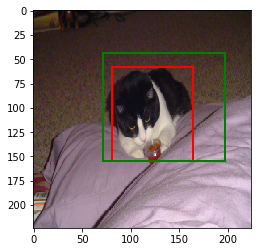

In [233]:
plot(y_test, y_pred, 'test')

## Save and Load the Model

In [234]:
# creates a HDF5 file 'localization_model.h5'
model.save('localization_model.h5')

In [ ]:
# returns a compiled model
# identical to the previous one
model = load_model('localization_model.h5')